In [2]:
from IPython.display import display

import pandas as pd
import warnings
from model_drift import settings, helpers
from model_drift.data.utils import nested2series
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from model_drift.drift.tabular import TabularDriftCalculator
from model_drift.drift.numeric import KSDriftCalculator, BasicDriftCalculator
from model_drift.drift.categorical import ChiSqDriftCalculator
from model_drift.drift.collection import DriftCollectionCalculator
from model_drift.drift.performance import AUROCCalculator

from model_drift.drift.sampler import Sampler
from model_drift.data.padchest import PadChest
import plotly.graph_objects as go

warnings.filterwarnings("ignore")


In [3]:
jsonl_file = str(settings.TOP_DIR.joinpath("results", 'vae', 'padchest-trained', 'preds.jsonl'))
vae_df = helpers.jsonl_files2dataframe(jsonl_file)
vae_df = pd.concat(
    [
        vae_df,
        pd.DataFrame(vae_df['mu'].values.tolist(), columns=[f"mu.{c}" for c in range(128)])
    ],
    axis=1
)
vae_df.head()

100%|██████████| 160819/160819 [00:18<00:00, 8486.95it/s]


,index,mu,logvar,error,mu.0,mu.1,mu.2,mu.3,mu.4,mu.5,...,mu.118,mu.119,mu.120,mu.121,mu.122,mu.123,mu.124,mu.125,mu.126,mu.127
0,20536686640136348236148679891455886468_k6ga29.png,"[0.004903476685285568, 0.00975932739675045, -0...","[0.00420594634488225, -0.032170265913009644, -...",0.007225,0.004903,0.009759,-0.840139,-0.016406,0.012096,0.021054,...,0.008214,-0.124864,-0.011458,-0.035856,-0.005253,-0.525054,-0.012718,-0.015304,1.603692,1.275674
1,113855343774216031107737439268243531979_3k951n...,"[-0.039043813943862915, -0.007190241944044828,...","[-0.013759884051978588, -0.012844430282711983,...",0.006071,-0.039044,-0.007190,-1.345544,0.016048,0.037869,-0.036479,...,0.042117,0.080279,0.014332,-0.000268,-0.019087,0.168344,-0.046811,-0.030200,-0.740812,-1.276945
2,313723174271082992847610802266403640553-4_hhi4...,"[-0.03004823438823223, -0.05634206160902977, 0...","[-0.010940825566649437, 0.017154257744550705, ...",0.013905,-0.030048,-0.056342,0.508030,-0.041828,-0.014656,0.010803,...,0.050155,0.336182,0.111974,0.046037,0.092280,-1.214425,0.014846,0.073163,0.226776,0.311751
3,105529804483623054726294337265160703666_6zn76a...,"[0.001704810420051217, -0.014846593141555786, ...","[-0.0063932850025594234, 0.010232711210846901,...",0.004213,0.001705,-0.014847,-0.050661,-0.013582,-0.015157,-0.007484,...,0.000933,0.042541,-0.017803,0.016669,-0.019601,-1.454505,-0.013419,0.012802,0.410283,0.671507
4,102185472428957491598043403159908631419_zb8kco...,"[-0.03474627062678337, -0.021671226248145103, ...","[-0.022024642676115036, -0.014861042611300945,...",0.009243,-0.034746,-0.021671,-1.811071,0.097347,-0.022849,-0.029674,...,-0.045857,-0.070322,0.004691,0.022646,-0.038137,0.053273,-0.028840,0.028752,-1.016176,-1.146801


In [4]:
from model_drift.data.padchest import LABEL_MAP
label_cols = list(LABEL_MAP)
jsonl_file = str(settings.TOP_DIR.joinpath("results", 'classifier', 'finetuned', "preds.jsonl"))
scores_df = helpers.jsonl_files2dataframe(jsonl_file)
scores_df = pd.concat(
    [
        scores_df,
        pd.DataFrame(scores_df['activation'].values.tolist(), columns=[f"activation.{c}" for c in label_cols])
    ],
    axis=1)
scores_df.head()


100%|██████████| 160819/160819 [00:03<00:00, 48937.92it/s]


,index,score,activation,label,activation.Atelectasis,activation.Cardiomegaly,activation.Consolidation,activation.Edema,activation.Lesion,activation.No Finding,activation.Opacity,activation.Pleural Abnormalities,activation.Pleural Effusion,activation.Pneumonia
0,20536686640136348236148679891455886468_k6ga29.png,"[-2.9898717403411865, 0.021230269223451614, -5...","[0.04788553714752197, 0.5053073763847351, 0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.047886,0.505307,0.003428,0.000492,0.031599,0.040083,0.046906,0.223817,0.010098,0.010910
1,113855343774216031107737439268243531979_3k951n...,"[-4.271155834197998, -3.2341253757476807, -7.5...","[0.013773280195891857, 0.03790152817964554, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.013773,0.037902,0.000529,0.000097,0.022773,0.269458,0.025679,0.003461,0.000689,0.003102
2,313723174271082992847610802266403640553-4_hhi4...,"[-1.9546648263931274, -4.485781669616699, -1.7...","[0.12404559552669525, 0.011142521165311337, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.124046,0.011143,0.148217,0.000012,0.022932,0.003598,0.751884,0.655488,0.479314,0.211316
3,105529804483623054726294337265160703666_6zn76a...,"[-2.843719244003296, -2.7252206802368164, -5.9...","[0.055006884038448334, 0.06150144338607788, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.055007,0.061501,0.002591,0.000115,0.016477,0.370590,0.017562,0.013063,0.001621,0.005887
4,102185472428957491598043403159908631419_zb8kco...,"[-2.794471502304077, -4.529303073883057, -5.34...","[0.05762365832924843, 0.01067304890602827, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.057624,0.010673,0.004754,0.000176,0.021283,0.097500,0.051552,0.037033,0.019453,0.026915


In [5]:
# Load padchest CSV
pc = PadChest(settings.PADCHEST_FILENAME)
pc.prepare()


pc.merge(vae_df, left_on="ImageID", right_on="index", how='inner')
pc.merge(scores_df, left_on="ImageID", right_on="index", how='inner')


train, val, test = pc.split(settings.PADCHEST_SPLIT_DATES, studydate_index=True)


In [6]:
pd.concat(
    {
        "all": pc.df["StudyDate"].describe(datetime_is_numeric=True),
        "train": train.df["StudyDate"].describe(datetime_is_numeric=True),
        "val": val.df["StudyDate"].describe(datetime_is_numeric=True),
        "test": test.df["StudyDate"].describe(datetime_is_numeric=True),
    },
    axis=1,
)


,all,train,val,test
count,160819,91726,22176,46917
mean,2012-09-14 20:54:45.910246912,2011-01-06 03:16:23.616423168,2013-06-16 00:14:59.999999744,2015-08-29 00:15:02.359485696
min,2007-05-03 00:00:00,2007-05-03 00:00:00,2013-01-01 00:00:00,2014-01-01 00:00:00
25%,2010-10-27 00:00:00,2010-01-19 00:00:00,2013-03-10 00:00:00,2014-08-08 00:00:00
50%,2012-06-18 00:00:00,2011-01-18 00:00:00,2013-06-04 00:00:00,2015-06-09 00:00:00
75%,2014-05-28 00:00:00,2012-01-11 00:00:00,2013-09-25 00:00:00,2016-09-13 00:00:00
max,2017-11-17 00:00:00,2012-12-28 00:00:00,2013-12-31 00:00:00,2017-11-17 00:00:00


In [7]:
FLOAT = KSDriftCalculator
CAT = ChiSqDriftCalculator

cols = {
    'age': FLOAT,
    'Projection': CAT,
    "PatientSex_DICOM": CAT,
    "ViewPosition_DICOM": CAT,
    "Modality_DICOM": CAT,
    "Manufacturer_DICOM": CAT,
    "PhotometricInterpretation_DICOM": CAT,
    "PixelRepresentation_DICOM": CAT,
    "PixelAspectRatio_DICOM": CAT,
    "SpatialResolution_DICOM": CAT,
    "BitsStored_DICOM": CAT,
    "WindowCenter_DICOM": FLOAT,
    "WindowWidth_DICOM": FLOAT,
    "Rows_DICOM": FLOAT,
    "Columns_DICOM": FLOAT,
    "XRayTubeCurrent_DICOM": CAT,
    "Exposure_DICOM": CAT,
    "ExposureInuAs_DICOM": FLOAT,
    "RelativeXRayExposure_DICOM": FLOAT,
    'Frontal': BasicDriftCalculator,
}

cols.update({c:FLOAT for c in list(pc.df) if c.startswith("mu.") and 'all' not in c})
cols.update({c:FLOAT for c in list(pc.df) if c.startswith("activation.") and 'all' not in c})
cols[("score", "label")] = AUROCCalculator


In [8]:
window = "30D"
stride = "D"
ref_frontal_only = True
min_periods = 150

nonfrontal_add_date = "2015-01-01"
frontal_remove_date = "2016-06-01"

replacement = True
sample_size = 2000
n_samples = 20


sampler = Sampler(sample_size, replacement=replacement)


In [19]:
refdf = val.df.copy()
if ref_frontal_only:
    refdf = refdf.query("Frontal")


print(len(refdf), len(val.df))

dwc = TabularDriftCalculator(refdf)

for c, kls in cols.items():
    dwc.add_drift_stat(c, kls)
dwc.prepare()

target_df = pc.df.set_index('StudyDate')


nonfrontals_target_df = target_df.query("~Frontal")
frontals_target_df = target_df.query("Frontal")


target_df = val.df.copy()#.query("Frontal")


# print(target_df['Frontal'].mean())
# target_df = pd.concat([frontals_target_df.loc[:frontal_remove_date],
#                       nonfrontals_target_df.loc[nonfrontal_add_date:]]).sort_index()
# print(target_df['Frontal'].mean())



print(len(target_df), len(pc.df.set_index('StudyDate')))


15267 22176
22176 160819


In [20]:
fname = settings.TOP_DIR.joinpath(
    "results", "drift_csvs", f"valwithnonfrontals-s{stride}-w{window}-min{min_periods}_frontalonly-ref{ref_frontal_only}_Samp-ss{sample_size}-n{n_samples}-repl{replacement}.csv")
print(fname)


D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\results\drift_csvs\valwithonlyfrontals-sD-w30D-min150_frontalonly-refTrue_Samp-ss2000-n20-replTrue.csv


100%|██████████| 365/365 [00:03<00:00, 114.83it/s]


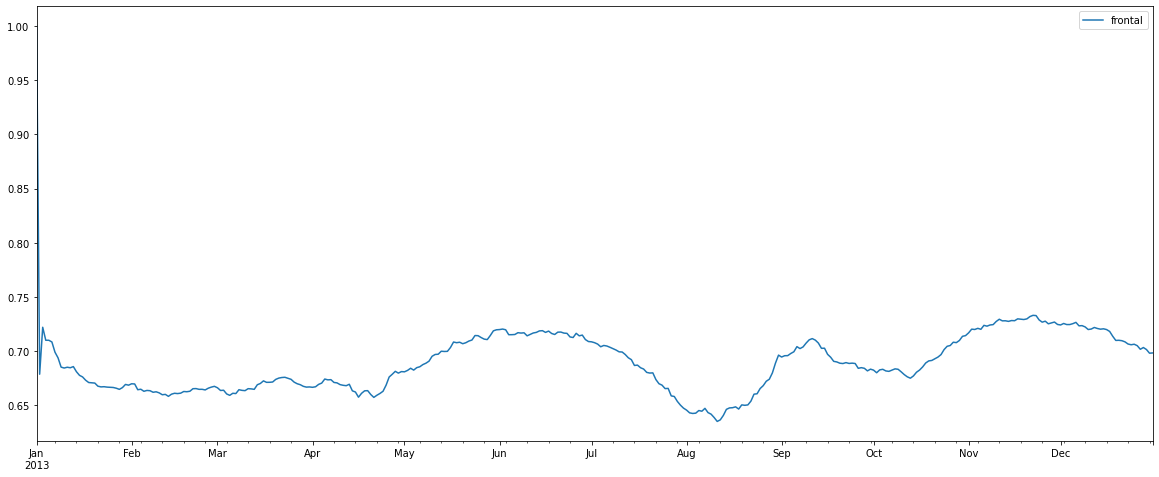

In [21]:
from model_drift.data.utils import rolling_window_dt_apply

frontal_over_time = rolling_window_dt_apply(target_df, lambda x: {'frontal': x['Frontal'].mean()}, n_jobs=5, backend='threading')

frontal_over_time.plot(y='frontal', figsize=(20, 8))


In [17]:
output = dwc.rolling_window_predict(target_df,
                                    sampler=sampler, n_samples=n_samples,
                                    stride=stride, window=window, min_periods=min_periods,
                                    n_jobs=5, backend="threading"
                                    )


100%|██████████| 365/365 [52:51<00:00,  8.69s/it]


In [18]:
print(fname)
output.to_csv(fname)


D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\results\drift_csvs\valwithonlyfrontals-sD-w30D-min150_frontalonly-refTrue_Samp-ss2000-n20-replTrue.csv


In [13]:
output.head()

BitsStored_DICOM                                                 \
                       chi2                                                  
              critical_diff                       critical_value             
                       mean        obs        std           mean       obs   
2009-01-06         1.540089  -2.582056   3.409763       2.705543  2.705543   
2009-01-07        23.943082   0.451021   7.315131       2.705543  2.705543   
2009-01-08        54.972558   8.185991  10.302677       2.705543  2.705543   
2009-01-09        75.300169  14.995869   9.283924       2.705543  2.705543   
2009-01-10        78.511304  15.086576  12.280183       2.705543  2.705543   

                                                                ...  \
                                                                ...   
                           distance                        dof  ...   
                     std       mean        obs        std mean  ...   
2009-01-06  4.556259e-16   4.245632   0.123488   3.409763  1.0  ...   
2009-01-07  4.556259e-16  26.648625   3.156564   7.315131  1.0  ...   
2009-01-08  4.556259e-16  57.678101  10.891534  10.302677  1.0  ...   
2009-01-09  4.556259e-16  78.005713  17.701413   9.283924  1.0  ...   
2009-01-10  4.556259e-16  81.216848  17.792120  12.280183  1.0  ...   

                    mu.99                                              \
                       ks                                               
           critical_value  distance                              pval   
                      std      mean       obs       std          mean   
2009-01-06            0.0  0.111847  0.113299  0.008451  2.143601e-16   
2009-01-07            0.0  0.092091  0.084327  0.006306  7.500897e-12   
2009-01-08            0.0  0.086986  0.080273  0.008847  2.319086e-09   
2009-01-09            0.0  0.075133  0.076932  0.005358  8.606445e-08   
2009-01-10            0.0  0.078960  0.076632  0.004984  4.894878e-09   

                                       score                      
                                       label                      
                                       auroc                      
                 obs           std      mean       obs       std  
2009-01-06  0.031096  6.328667e-16  0.920199  0.920836  0.002782  
2009-01-07  0.053870  2.506300e-11  0.932706  0.933196  0.003153  
2009-01-08  0.020760  7.673355e-09  0.935813  0.936193  0.002932  
2009-01-09  0.010724  1.867215e-07  0.930371  0.930507  0.002905  
2009-01-10  0.011038  9.432373e-09  0.931151  0.930454  0.003383  

[5 rows x 1923 columns]

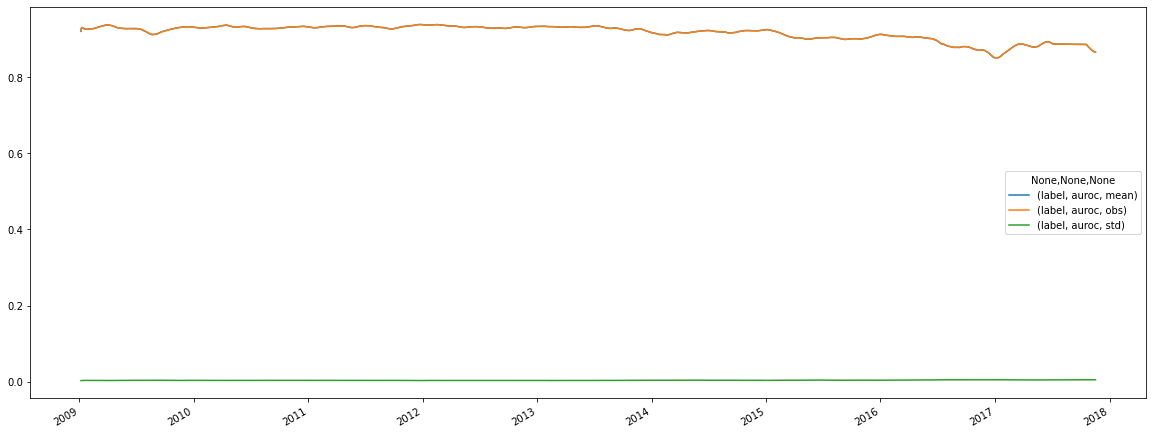

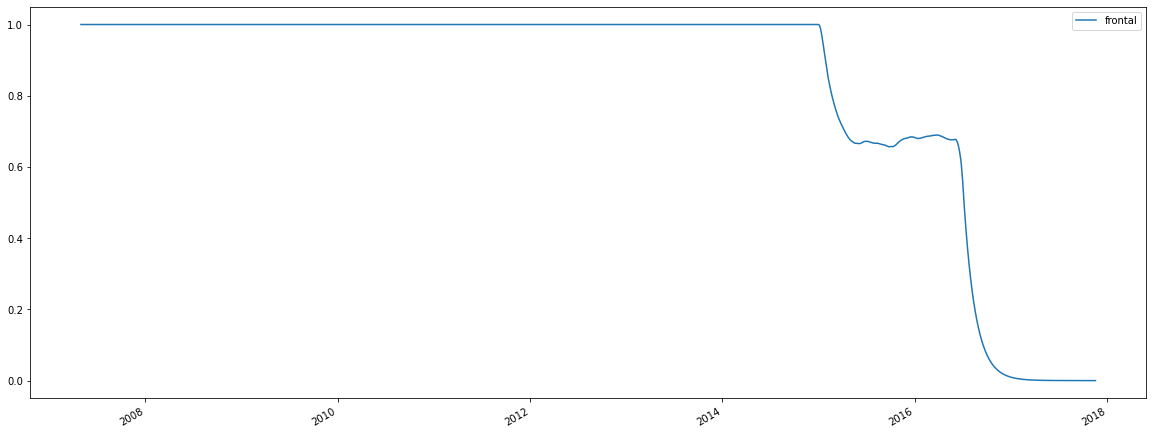

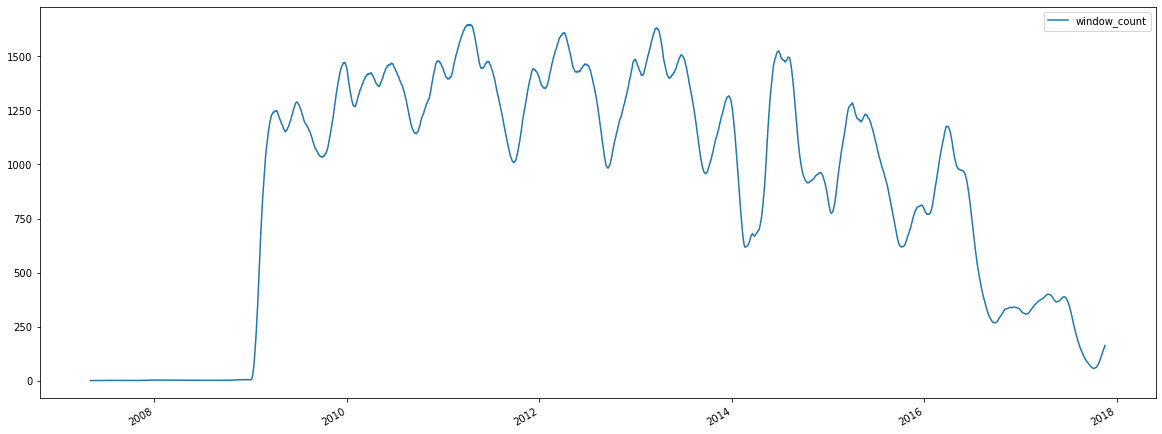

In [14]:


output['score'].ewm(span=90).mean().plot(figsize=(20, 8))

frontal_over_time.ewm(span=90).mean().plot(y='frontal', figsize=(20, 8))

frontal_over_time.ewm(span=90).mean().plot(y='window_count', figsize=(20, 8))


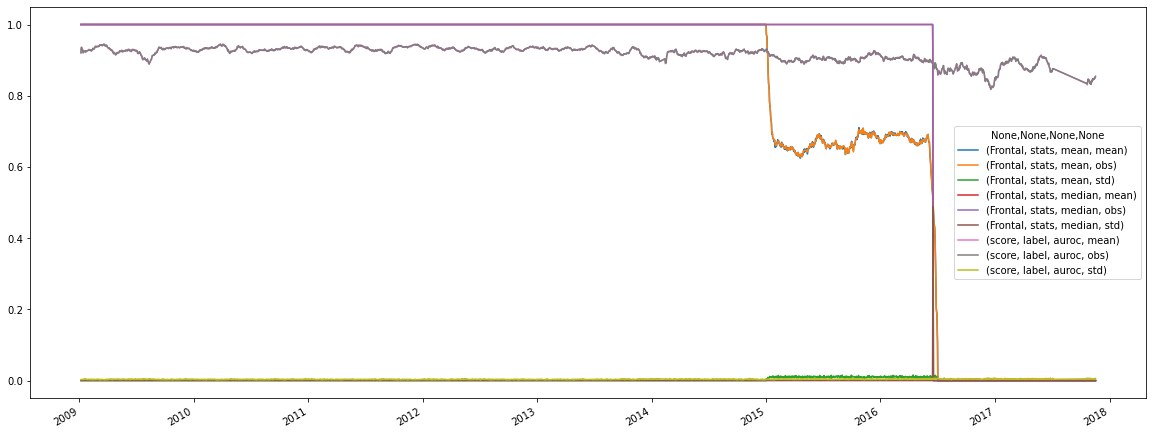

In [15]:
output[["Frontal", 'score']].drop([("Frontal", 'stats', "std")], axis=1).plot(figsize=(20, 8))
